# Reflectance of a Waveguide Taper

This example involves computing the reflectance of the fundamental mode of a linear waveguide taper. We will verify that computing the reflectance, the fraction of the incident power which is reflected, using two different methods produces nearly identical results: (1) mode decomposition and (2) [Poynting flux](../Introduction.md#transmittancereflectance-spectra). Also, we will demonstrate that the scaling of the reflectance with the taper length is quadratic, consistent with analytical results from [Optics Express, Vol. 16, pp. 11376-92, 2008](http://www.opticsinfobase.org/abstract.cfm?URI=oe-16-15-11376).

The structure, which can be viewed as a [two-port network](https://en.wikipedia.org/wiki/Two-port_network), consists of a single-mode waveguide of width 1 μm (`w1`) at a wavelength of 6.67 μm and coupled to a second waveguide of width 2 μm (`w2`) via a linearly-sloped taper of variable length `Lt`. 

The core material is dispersive silicon and the cladding is dispersive silicon dioxide (imported from the materials library). The taper geometry is defined using a single [`Prism`](../Python_User_Interface.md#prism) object with eight vertices. PML absorbing boundaries surround the entire cell. 

An eigenmode current source with E<sub>z</sub> polarization is used to launch the fundamental mode. The dispersion relation (or "band diagram") of the single-mode waveguide is shown in [Tutorial/Eigenmode Source](Eigenmode_Source.md). 

There is an eigenmode-expansion monitor placed at the midpoint of the first waveguide. This is a line monitor which extends beyond the waveguide in order to span the entire mode profile including its evanescent tails. The Fourier-transformed fields along this line monitor are used to compute the basis coefficients of the harmonic modes. These are computed separately via the eigenmode solver [MPB](https://mpb.readthedocs.io/en/latest/). This is described in [Mode Decomposition](../Mode_Decomposition.md) where it is also shown that the squared magnitude of the mode coefficient is equivalent to the power (Poynting flux) in the given eigenmode. The ratio of the complex mode coefficients can be used to compute the [S parameters](https://en.wikipedia.org/wiki/Scattering_parameters). 

In this example, we are computing |S<sub>11</sub>|<sup>2</sup> which is the reflectance (shown in the line prefixed by "refl:,"). Another line monitor could have been placed in the second waveguide to compute the transmittance or |S<sub>21</sub>|<sup>2</sup> into the various guided modes (since the second waveguide is multi mode). The scattered power into the radiative modes can then be computed as 1-|S<sub>11</sub>|<sup>2</sup>-|S<sub>21</sub>|<sup>2</sup>. As usual, a normalization run is required involving a straight waveguide to compute the power in the source.

The structure has mirror symmetry in the $y$ direction which can be exploited to reduce the computation size by a factor of two. This requires that we use `add_flux` rather than `add_mode_monitor` (which is not optimized for symmetry) and specify `eig_parity=mp.ODD_Z+mp.EVEN_Y` in the call to `get_eigenmode_coefficients`.

First we'll begin by loading our modules and materials from Meep's material library:

In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from meep.materials import Si, SiO2

Using MPI version 3.1, 1 processes


Now we can define our waveguide taper geometric parameters:

In [2]:
w1 = 1.0          # width of waveguide 1
w2 = 2.0          # width of waveguide 2
Lw = 10.0         # length of waveguides 1 and 2
Lt = 2            # length of waveguide taper

We'll specify the simulation domain parameters, such as the simulation resolution, boundary layers, simulation cell size, and we'll also leverage a symmetry across the `X` axis.

In [3]:
resolution = 40   # pixels/μm

dair = 3.0        # length of air region
dpml_x = 6.0      # length of PML in x direction
dpml_y = 2.0      # length of PML in y direction

boundary_layers = [mp.PML(dpml_x,direction=mp.X),
                   mp.PML(dpml_y,direction=mp.Y)]

sy = dpml_y+dair+w2+dair+dpml_y
sx = dpml_x+Lw+Lt+Lw+dpml_x
cell_size = mp.Vector3(sx,sy,0)

symmetries = [mp.Mirror(mp.Y)]

Next we'll define a straight waveguide structure.

In [4]:
vertices = [mp.Vector3(-0.5*sx-1,0.5*w1),
                mp.Vector3(0.5*sx+1,0.5*w1),
                mp.Vector3(0.5*sx+1,-0.5*w1),
                mp.Vector3(-0.5*sx-1,-0.5*w1)]
geometry=[mp.Prism(vertices,height=mp.inf,material=Si)]

We'll add a broadband Gaussian pulse source.

In [5]:
lcen = 6.67       # mode wavelength
fcen = 1/lcen     # mode frequency
df = 0.2*fcen

src_pt = mp.Vector3(-0.5*sx+dpml_x+0.2*Lw)
sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              center=src_pt,
                              size=mp.Vector3(y=sy-2*dpml_y),
                              eig_match_freq=True,
                              eig_parity=mp.ODD_Z+mp.EVEN_Y)]

We can now formulate our simulation object and add a flux monitor to the simulation. We can use this flux monitor for both the flux calculations and the mode expansion calculations, we just need to be wary of the symmetries. As explained in the documentation, using a flux monitor for mode decomposition calculations does not check for modes that don't follow the specified symmetry. Luckily, we are only solving for the fundamental mode that _does_ obey this symmetry.

In [6]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    default_material=SiO2,
                    Courant=0.2,
                    symmetries=symmetries)

mon_pt = mp.Vector3(-0.5*sx+dpml_x+0.7*Lw)
flux = sim.add_flux(fcen,0,1,mp.FluxRegion(center=mon_pt,size=mp.Vector3(y=sy-2*dpml_y)))

We'll visualize the waveguide structure:

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00279381 s
Working in 2D dimensions.
Computational cell is 34 x 12 x 0 with resolution 40
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 4 vertices:
          (-18,0.5,0)
          (18,0.5,0)
          (18,-0.5,0)
          (-18,-0.5,0)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.880867 s
lorentzian susceptibility: frequency=9.67865, gamma=0.0806554
lorentzian susceptibility: frequency=0.000905797, gamma=0
lorentzian susceptibility: frequency=0.88125, gamma=0
lorentzian susceptibility: frequency=3.31657, gamma=0
-----------
MPB solved for omega_1(0.512677,0,0) = 0.174342 after 9 iters
MPB solved for omega_1(0.426027,0,0) = 0.149863 after 7 iters
MPB solved for omega_1(0.426247,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.426247,0,0) = 0.149925 after 1 iters


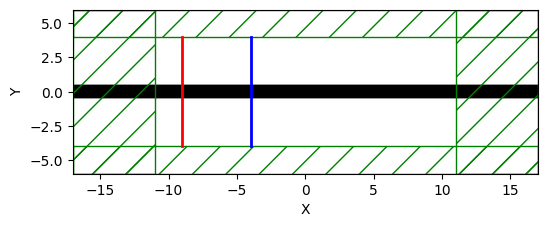

In [7]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

and run the simulation until the fields sufficiently decay.

In [8]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mon_pt,1e-9))

on time step 179 (time=0.895), 0.0224254 s/step
on time step 351 (time=1.755), 0.0233881 s/step
on time step 522 (time=2.61), 0.0235193 s/step
on time step 693 (time=3.465), 0.0234868 s/step
on time step 867 (time=4.335), 0.0229984 s/step
on time step 1044 (time=5.22), 0.0226957 s/step
on time step 1220 (time=6.1), 0.0227416 s/step
on time step 1394 (time=6.97), 0.02305 s/step
on time step 1566 (time=7.83), 0.023265 s/step
on time step 1736 (time=8.68), 0.0236672 s/step
on time step 1910 (time=9.55), 0.0230019 s/step
on time step 2071 (time=10.355), 0.0248979 s/step
on time step 2239 (time=11.195), 0.0238286 s/step
on time step 2404 (time=12.02), 0.0242641 s/step
on time step 2564 (time=12.82), 0.0250229 s/step
on time step 2724 (time=13.62), 0.0250345 s/step
on time step 2885 (time=14.425), 0.0249881 s/step
on time step 3046 (time=15.23), 0.0249788 s/step
on time step 3209 (time=16.045), 0.0246578 s/step
on time step 3365 (time=16.825), 0.0258037 s/step
on time step 3519 (time=17.595)

on time step 30288 (time=151.44), 0.0197349 s/step
on time step 30490 (time=152.45), 0.0198227 s/step
on time step 30693 (time=153.465), 0.0197605 s/step
on time step 30897 (time=154.485), 0.0196541 s/step
on time step 31101 (time=155.505), 0.0196882 s/step
on time step 31303 (time=156.515), 0.0198391 s/step
on time step 31507 (time=157.535), 0.0196663 s/step
on time step 31708 (time=158.54), 0.019919 s/step
on time step 31911 (time=159.555), 0.0197153 s/step
on time step 32114 (time=160.57), 0.0197925 s/step
on time step 32316 (time=161.58), 0.0198288 s/step
on time step 32520 (time=162.6), 0.0196976 s/step
on time step 32722 (time=163.61), 0.0198049 s/step
on time step 32923 (time=164.615), 0.0199054 s/step
on time step 33125 (time=165.625), 0.0198947 s/step
on time step 33324 (time=166.62), 0.0201825 s/step
on time step 33528 (time=167.64), 0.0196558 s/step
on time step 33731 (time=168.655), 0.0197803 s/step
on time step 33933 (time=169.665), 0.0198646 s/step
on time step 34137 (tim

on time step 61308 (time=306.54), 0.0203127 s/step
on time step 61507 (time=307.535), 0.0201655 s/step
on time step 61707 (time=308.535), 0.0200632 s/step
on time step 61906 (time=309.53), 0.0201637 s/step
on time step 62106 (time=310.53), 0.0200194 s/step
on time step 62304 (time=311.52), 0.0202599 s/step
on time step 62503 (time=312.515), 0.0201065 s/step
on time step 62702 (time=313.51), 0.02017 s/step
on time step 62900 (time=314.5), 0.0202211 s/step
on time step 63095 (time=315.475), 0.0205151 s/step
on time step 63291 (time=316.455), 0.0204169 s/step
on time step 63489 (time=317.445), 0.0202075 s/step
on time step 63688 (time=318.44), 0.0201806 s/step
on time step 63886 (time=319.43), 0.0202051 s/step
on time step 64083 (time=320.415), 0.0203202 s/step
on time step 64283 (time=321.415), 0.0200348 s/step
on time step 64482 (time=322.41), 0.0201539 s/step
on time step 64681 (time=323.405), 0.0201178 s/step
on time step 64878 (time=324.39), 0.0203303 s/step
on time step 65075 (time=

We now need to record the fluxes at the monitor so we can use them to normalize the taper responses later.

In [9]:
incident_flux = mp.get_fluxes(flux)

With a "calibration" run stored, we can proceed to the actual taper structure. We'll build our geometry:

In [10]:
vertices = [mp.Vector3(-0.5*sx-1,0.5*w1),
                mp.Vector3(-0.5*Lt,0.5*w1),
                mp.Vector3(0.5*Lt,0.5*w2),
                mp.Vector3(0.5*sx+1,0.5*w2),
                mp.Vector3(0.5*sx+1,-0.5*w2),
                mp.Vector3(0.5*Lt,-0.5*w2),
                mp.Vector3(-0.5*Lt,-0.5*w1),
                mp.Vector3(-0.5*sx-1,-0.5*w1)]
    
geometry=[mp.Prism(vertices,height=mp.inf,material=Si)]

and reformulate our simulation object:

In [11]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    default_material=SiO2,
                    Courant=0.2,
                    symmetries=symmetries)

mon_pt = mp.Vector3(-0.5*sx+dpml_x+0.7*Lw)
flux = sim.add_flux(fcen,0,1,mp.FluxRegion(center=mon_pt,size=mp.Vector3(y=sy-2*dpml_y)))

As usual, we'll visualize the structure:

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0014841 s
Working in 2D dimensions.
Computational cell is 34 x 12 x 0 with resolution 40
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-18,0.5,0)
          (-1,0.5,0)
          (1,1,0)
          (18,1,0)
          (18,-1,0)
          (1,-1,0)
          (-1,-0.5,0)
          (-18,-0.5,0)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 1.1621 s
lorentzian susceptibility: frequency=9.67865, gamma=0.0806554
lorentzian susceptibility: frequency=0.000905797, gamma=0
lorentzian susceptibility: frequency=0.88125, gamma=0
lorentzian susceptibility: frequency=3.31657, gamma=0
-----------
MPB solved for omega_1(0.512677,0,0) = 0.174342 after 9 iters
MPB solved for omega_1(0.426027,0,0) = 0.149863 after 7 iters
MPB solved for omega_1(0.426247,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.426247,

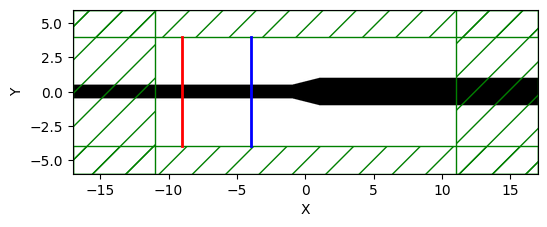

In [12]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

As we run this simulation, we'll record the fields so that we can animate the results.

In [13]:
f = plt.figure(dpi=150)
Animate = mp.Animate2D(sim,fields=mp.Ez,f=f,normalize=True)
sim.run(mp.at_every(1,Animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mon_pt,1e-9))
plt.close()

on time step 199 (time=0.995), 0.0201926 s/step
on time step 200 (time=1), 5.56103 s/step
on time step 388 (time=1.94), 0.0213545 s/step
on time step 576 (time=2.88), 0.0213172 s/step
on time step 765 (time=3.825), 0.0211768 s/step
on time step 954 (time=4.77), 0.0211671 s/step
on time step 1143 (time=5.715), 0.0212692 s/step
on time step 1330 (time=6.65), 0.021494 s/step
on time step 1516 (time=7.58), 0.0215472 s/step
on time step 1701 (time=8.505), 0.0217261 s/step
on time step 1887 (time=9.435), 0.0215779 s/step
on time step 2068 (time=10.34), 0.0221095 s/step
on time step 2239 (time=11.195), 0.0235234 s/step
on time step 2405 (time=12.025), 0.0241998 s/step
on time step 2575 (time=12.875), 0.0235753 s/step
on time step 2741 (time=13.705), 0.0242406 s/step
on time step 2904 (time=14.52), 0.024674 s/step
on time step 3076 (time=15.38), 0.0233036 s/step
on time step 3245 (time=16.225), 0.0236711 s/step
on time step 3414 (time=17.07), 0.0237742 s/step
on time step 3591 (time=17.955), 0

on time step 31357 (time=156.785), 0.0200362 s/step
on time step 31559 (time=157.795), 0.0198816 s/step
on time step 31759 (time=158.795), 0.0200663 s/step
on time step 31961 (time=159.805), 0.0198739 s/step
on time step 32161 (time=160.805), 0.0200173 s/step
on time step 32362 (time=161.81), 0.0199837 s/step
on time step 32565 (time=162.825), 0.0197957 s/step
on time step 32765 (time=163.825), 0.0200718 s/step
on time step 32966 (time=164.83), 0.0199867 s/step
on time step 33167 (time=165.835), 0.0199876 s/step
on time step 33367 (time=166.835), 0.0200251 s/step
on time step 33568 (time=167.84), 0.0199396 s/step
on time step 33767 (time=168.835), 0.0201192 s/step
on time step 33969 (time=169.845), 0.0198694 s/step
on time step 34168 (time=170.84), 0.0201213 s/step
on time step 34367 (time=171.835), 0.0201504 s/step
on time step 34569 (time=172.845), 0.0198364 s/step
on time step 34769 (time=173.845), 0.0200587 s/step
on time step 34970 (time=174.85), 0.0199659 s/step
on time step 3516

on time step 62378 (time=311.89), 0.0200933 s/step
on time step 62579 (time=312.895), 0.0199125 s/step
on time step 62778 (time=313.89), 0.0201685 s/step
on time step 62977 (time=314.885), 0.0201613 s/step
on time step 63179 (time=315.895), 0.0198578 s/step
on time step 63379 (time=316.895), 0.0200015 s/step
on time step 63580 (time=317.9), 0.0199231 s/step
on time step 63779 (time=318.895), 0.0201408 s/step
on time step 63978 (time=319.89), 0.0201357 s/step
on time step 64179 (time=320.895), 0.0199471 s/step
on time step 64378 (time=321.89), 0.0201448 s/step
on time step 64579 (time=322.895), 0.019979 s/step
on time step 64777 (time=323.885), 0.0202157 s/step
on time step 64977 (time=324.885), 0.0200807 s/step
on time step 65177 (time=325.885), 0.0200421 s/step
on time step 65377 (time=326.885), 0.0200683 s/step
on time step 65577 (time=327.885), 0.0200421 s/step
on time step 65775 (time=328.875), 0.0202242 s/step
on time step 65975 (time=329.875), 0.0200949 s/step
on time step 66176 

We'll export an mp4 video and visualize the results:

In [14]:
filename = "media/taper.mp4"
Animate.to_mp4(10,filename)
Video(filename)

Generating MP4...


As before, we want to record the fluxes.

In [15]:
taper_flux = mp.get_fluxes(flux)
norm_flux = -(taper_flux[0] - incident_flux[0]) /incident_flux[0]

In [16]:
res = sim.get_eigenmode_coefficients(flux,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)
a = res.alpha[0,0,0]
b = res.alpha[0,0,1]
S11 = b/a

MPB solved for omega_1(0.512677,0,0) = 0.174342 after 9 iters
MPB solved for omega_1(0.426027,0,0) = 0.149863 after 7 iters
MPB solved for omega_1(0.426247,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.426247,0,0) = 0.149925 after 1 iters
Dominant planewave for band 1: (0.426247,-0.000000,0.000000)


In [17]:
print("Reflected Power calculated by Flux Monitors: {:.2f} dB".format(10*np.log10(norm_flux)))
print("Reflected Power calculated by Mode Expansion Monitors: {:.2f} dB".format(10*np.log10(abs(S11)**2)))

Reflected Power calculated by Flux Monitors: -41.25 dB
Reflected Power calculated by Mode Expansion Monitors: -40.97 dB


In [18]:
def run_sim(Lt):
    sy = dpml_y+dair+w2+dair+dpml_y
    sx = dpml_x+Lw+Lt+Lw+dpml_x
    cell_size = mp.Vector3(sx,sy,0)

    vertices = [mp.Vector3(-0.5*sx-1,0.5*w1),
                mp.Vector3(-0.5*Lt,0.5*w1),
                mp.Vector3(0.5*Lt,0.5*w2),
                mp.Vector3(0.5*sx+1,0.5*w2),
                mp.Vector3(0.5*sx+1,-0.5*w2),
                mp.Vector3(0.5*Lt,-0.5*w2),
                mp.Vector3(-0.5*Lt,-0.5*w1),
                mp.Vector3(-0.5*sx-1,-0.5*w1)]
    
    geometry=[mp.Prism(vertices,height=mp.inf,material=Si)]
    
    src_pt = mp.Vector3(-0.5*sx+dpml_x+0.2*Lw,0,0)
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              center=src_pt,
                              size=mp.Vector3(y=sy-2*dpml_y),
                              eig_match_freq=True,
                              eig_parity=mp.ODD_Z+mp.EVEN_Y)]
    
    sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    Courant=0.2,
                    symmetries=symmetries)

    mon_pt = mp.Vector3(-0.5*sx+dpml_x+0.7*Lw,0,0)
    flux = sim.add_flux(fcen,0,1,mp.FluxRegion(center=mon_pt,size=mp.Vector3(y=sy-2*dpml_y)))
    
    f = plt.figure(dpi=100)
    sim.plot2D(ax=f.gca())
    plt.show()
    
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mon_pt,1e-9))
    
    taper_flux = mp.get_fluxes(flux)
    norm_flux = -(taper_flux[0] - incident_flux[0]) /incident_flux[0]
    
    res = sim.get_eigenmode_coefficients(flux,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)
    a = res.alpha[0,0,0]
    b = res.alpha[0,0,1]
    S11 = b/a
    
    return S11, norm_flux

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00167056 s
Working in 2D dimensions.
Computational cell is 33 x 12 x 0 with resolution 40
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-17.5,0.5,0)
          (-0.5,0.5,0)
          (0.5,1,0)
          (17.5,1,0)
          (17.5,-1,0)
          (0.5,-1,0)
          (-0.5,-0.5,0)
          (-17.5,-0.5,0)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 1.12449 s
lorentzian susceptibility: frequency=0.000905797, gamma=0
lorentzian susceptibility: frequency=0.88125, gamma=0
lorentzian susceptibility: frequency=3.31657, gamma=0
-----------
MPB solved for omega_1(0.512677,0,0) = 0.17556 after 10 iters
MPB solved for omega_1(0.420991,0,0) = 0.149885 after 8 iters
MPB solved for omega_1(0.421133,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.421133,0,0) = 0.149925 after 1 iters


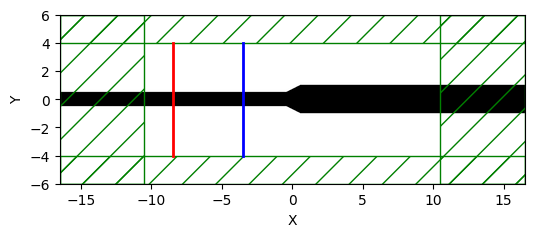

on time step 246 (time=1.23), 0.0163027 s/step
on time step 482 (time=2.41), 0.0169539 s/step
on time step 710 (time=3.55), 0.0176011 s/step
on time step 950 (time=4.75), 0.016731 s/step
on time step 1178 (time=5.89), 0.0175477 s/step
on time step 1415 (time=7.075), 0.0169079 s/step
on time step 1654 (time=8.27), 0.01676 s/step
on time step 1875 (time=9.375), 0.0181068 s/step
on time step 2099 (time=10.495), 0.0179166 s/step
on time step 2323 (time=11.615), 0.017904 s/step
on time step 2544 (time=12.72), 0.0181104 s/step
on time step 2768 (time=13.84), 0.0178969 s/step
on time step 3003 (time=15.015), 0.0170583 s/step
on time step 3248 (time=16.24), 0.0163838 s/step
on time step 3500 (time=17.5), 0.0158753 s/step
on time step 3757 (time=18.785), 0.0156176 s/step
on time step 4008 (time=20.04), 0.0159397 s/step
on time step 4261 (time=21.305), 0.0158559 s/step
on time step 4515 (time=22.575), 0.0157992 s/step
on time step 4769 (time=23.845), 0.0157897 s/step
on time step 5018 (time=25.0

on time step 39487 (time=197.435), 0.0170406 s/step
on time step 39725 (time=198.625), 0.0168165 s/step
on time step 39958 (time=199.79), 0.0172335 s/step
field decay(t = 200.02): 1.561874196778589 / 1.561874196778589 = 1.0
on time step 40201 (time=201.005), 0.0165144 s/step
on time step 40450 (time=202.25), 0.0161256 s/step
on time step 40701 (time=203.505), 0.0159423 s/step
on time step 40950 (time=204.75), 0.0161203 s/step
on time step 41202 (time=206.01), 0.0159008 s/step
on time step 41450 (time=207.25), 0.0161335 s/step
on time step 41701 (time=208.505), 0.0159505 s/step
on time step 41954 (time=209.77), 0.0158168 s/step
on time step 42203 (time=211.015), 0.0161029 s/step
on time step 42457 (time=212.285), 0.0157944 s/step
on time step 42707 (time=213.535), 0.0160458 s/step
on time step 42955 (time=214.775), 0.0161685 s/step
on time step 43205 (time=216.025), 0.0160194 s/step
on time step 43433 (time=217.165), 0.0175809 s/step
on time step 43680 (time=218.4), 0.0162143 s/step
on 

on time step 77631 (time=388.155), 0.0167579 s/step
on time step 77876 (time=389.38), 0.0163629 s/step
on time step 78114 (time=390.57), 0.0168368 s/step
on time step 78354 (time=391.77), 0.0166676 s/step
on time step 78724 (time=393.62), 0.0108177 s/step
on time step 79139 (time=395.695), 0.00963902 s/step
on time step 79419 (time=397.095), 0.0237093 s/step
on time step 79652 (time=398.26), 0.0172018 s/step
field decay(t = 400.04): 6.172363899707551e-11 / 1.561874196778589 = 3.951895685605301e-11
run 0 finished at t = 400.04 (80008 timesteps)
MPB solved for omega_1(0.512677,0,0) = 0.17556 after 10 iters
MPB solved for omega_1(0.420991,0,0) = 0.149885 after 8 iters
MPB solved for omega_1(0.421133,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.421133,0,0) = 0.149925 after 1 iters
Dominant planewave for band 1: (0.421133,-0.000000,0.000000)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00162045 s
Working in 2D

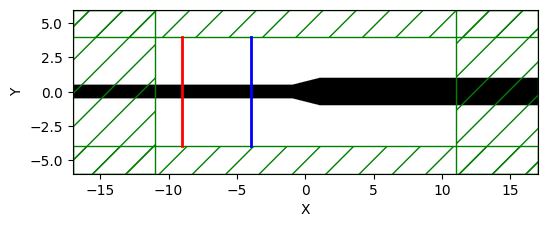

on time step 435 (time=2.175), 0.00920635 s/step
on time step 861 (time=4.305), 0.00939139 s/step
on time step 1281 (time=6.405), 0.00952431 s/step
on time step 1711 (time=8.555), 0.00930284 s/step
on time step 2133 (time=10.665), 0.00949804 s/step
on time step 2514 (time=12.57), 0.0105034 s/step
on time step 2892 (time=14.46), 0.0105907 s/step
on time step 3326 (time=16.63), 0.00922348 s/step
on time step 3802 (time=19.01), 0.00841678 s/step
on time step 4277 (time=21.385), 0.00843783 s/step
on time step 4753 (time=23.765), 0.0084111 s/step
on time step 5229 (time=26.145), 0.00841124 s/step
on time step 5705 (time=28.525), 0.00841038 s/step
on time step 6181 (time=30.905), 0.00840957 s/step
on time step 6657 (time=33.285), 0.00841375 s/step
on time step 7133 (time=35.665), 0.00841207 s/step
on time step 7609 (time=38.045), 0.00841371 s/step
on time step 8085 (time=40.425), 0.00842001 s/step
on time step 8561 (time=42.805), 0.0084096 s/step
on time step 9037 (time=45.185), 0.00841694 s

field decay(t = 350.035): 8.149525330376457e-06 / 1.5416360149668964 = 5.286283695539801e-06
on time step 70248 (time=351.24), 0.00961807 s/step
on time step 70708 (time=353.54), 0.00871368 s/step
on time step 71161 (time=355.805), 0.00883261 s/step
on time step 71618 (time=358.09), 0.0087695 s/step
on time step 72078 (time=360.39), 0.00871228 s/step
on time step 72552 (time=362.76), 0.0084529 s/step
on time step 73026 (time=365.13), 0.00845494 s/step
on time step 73464 (time=367.32), 0.00915114 s/step
on time step 73885 (time=369.425), 0.00951536 s/step
on time step 74317 (time=371.585), 0.009263 s/step
on time step 74737 (time=373.685), 0.00952484 s/step
on time step 75157 (time=375.785), 0.00952773 s/step
on time step 75628 (time=378.14), 0.00849864 s/step
on time step 76100 (time=380.5), 0.00849205 s/step
on time step 76566 (time=382.83), 0.00859563 s/step
on time step 77036 (time=385.18), 0.00852927 s/step
on time step 77496 (time=387.48), 0.00869941 s/step
on time step 77965 (tim

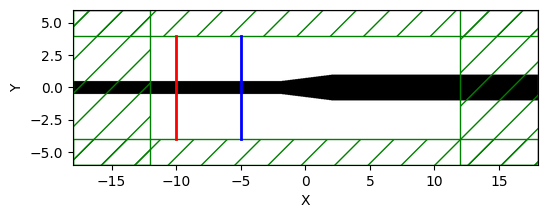

on time step 383 (time=1.915), 0.0104551 s/step
on time step 739 (time=3.695), 0.0112636 s/step
on time step 1117 (time=5.585), 0.0106133 s/step
on time step 1456 (time=7.28), 0.0118217 s/step
on time step 1795 (time=8.975), 0.0118045 s/step
on time step 2152 (time=10.76), 0.0112181 s/step
on time step 2524 (time=12.62), 0.0107794 s/step
on time step 2872 (time=14.36), 0.0114958 s/step
on time step 3217 (time=16.085), 0.0116226 s/step
on time step 3608 (time=18.04), 0.0102437 s/step
on time step 4037 (time=20.185), 0.00934483 s/step
on time step 4466 (time=22.33), 0.00932944 s/step
on time step 4895 (time=24.475), 0.00933888 s/step
on time step 5325 (time=26.625), 0.00932117 s/step
on time step 5755 (time=28.775), 0.00932364 s/step
on time step 6185 (time=30.925), 0.00932389 s/step
on time step 6613 (time=33.065), 0.00936284 s/step
on time step 7041 (time=35.205), 0.00935511 s/step
on time step 7469 (time=37.345), 0.00936661 s/step
on time step 7898 (time=39.49), 0.00933529 s/step
on t

on time step 63650 (time=318.25), 0.0093257 s/step
on time step 64079 (time=320.395), 0.00933818 s/step
on time step 64508 (time=322.54), 0.0093249 s/step
on time step 64937 (time=324.685), 0.00933256 s/step
on time step 65366 (time=326.83), 0.00933512 s/step
on time step 65795 (time=328.975), 0.00933404 s/step
on time step 66224 (time=331.12), 0.00933339 s/step
on time step 66653 (time=333.265), 0.00933522 s/step
on time step 67082 (time=335.41), 0.00932703 s/step
on time step 67511 (time=337.555), 0.00932489 s/step
on time step 67941 (time=339.705), 0.00931462 s/step
on time step 68371 (time=341.855), 0.00931599 s/step
on time step 68800 (time=344), 0.009333 s/step
on time step 69229 (time=346.145), 0.00933209 s/step
on time step 69659 (time=348.295), 0.00931216 s/step
field decay(t = 350.035): 6.533275409647436e-06 / 1.541125233237376 = 4.2392891043145555e-06
on time step 70089 (time=350.445), 0.00932084 s/step
on time step 70519 (time=352.595), 0.00932102 s/step
on time step 70948 

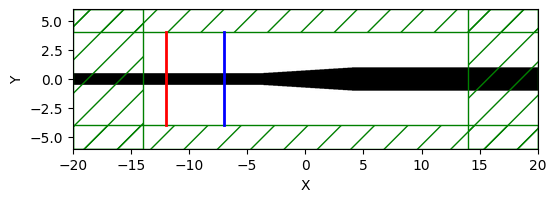

on time step 362 (time=1.81), 0.0110781 s/step
on time step 719 (time=3.595), 0.0112049 s/step
on time step 1079 (time=5.395), 0.0111334 s/step
on time step 1437 (time=7.185), 0.0112042 s/step
on time step 1792 (time=8.96), 0.0112961 s/step
on time step 2143 (time=10.715), 0.0114235 s/step
on time step 2493 (time=12.465), 0.0114372 s/step
on time step 2842 (time=14.21), 0.0114736 s/step
on time step 3175 (time=15.875), 0.012013 s/step
on time step 3491 (time=17.455), 0.0126937 s/step
on time step 3806 (time=19.03), 0.0127371 s/step
on time step 4139 (time=20.695), 0.0120365 s/step
on time step 4525 (time=22.625), 0.0103755 s/step
on time step 4910 (time=24.55), 0.0104006 s/step
on time step 5297 (time=26.485), 0.01036 s/step
on time step 5682 (time=28.41), 0.0104044 s/step
on time step 6067 (time=30.335), 0.0103939 s/step
on time step 6452 (time=32.26), 0.0103918 s/step
on time step 6837 (time=34.185), 0.0103977 s/step
on time step 7222 (time=36.11), 0.0104071 s/step
on time step 7607 

on time step 59164 (time=295.82), 0.010858 s/step
on time step 59533 (time=297.665), 0.0108582 s/step
on time step 59919 (time=299.595), 0.0103746 s/step
field decay(t = 300.03000000000003): 0.029719924435892837 / 1.5437660554442825 = 0.01925157269204219
on time step 60304 (time=301.52), 0.0104057 s/step
on time step 60690 (time=303.45), 0.0103848 s/step
on time step 61070 (time=305.35), 0.0105522 s/step
on time step 61454 (time=307.27), 0.0104278 s/step
on time step 61840 (time=309.2), 0.0103661 s/step
on time step 62226 (time=311.13), 0.0103825 s/step
on time step 62612 (time=313.06), 0.0103757 s/step
on time step 62998 (time=314.99), 0.0103701 s/step
on time step 63384 (time=316.92), 0.0103833 s/step
on time step 63771 (time=318.855), 0.0103576 s/step
on time step 64156 (time=320.78), 0.0104043 s/step
on time step 64542 (time=322.71), 0.0103848 s/step
on time step 64928 (time=324.64), 0.0103776 s/step
on time step 65312 (time=326.56), 0.0104188 s/step
on time step 65698 (time=328.49

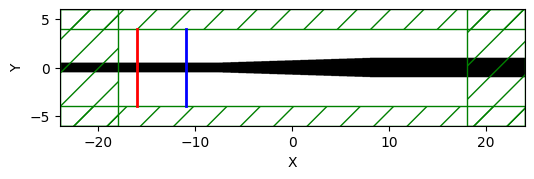

on time step 352 (time=1.76), 0.0113677 s/step
on time step 702 (time=3.51), 0.0114476 s/step
on time step 1057 (time=5.285), 0.0112909 s/step
on time step 1409 (time=7.045), 0.0113693 s/step
on time step 1758 (time=8.79), 0.0114921 s/step
on time step 2106 (time=10.53), 0.0115172 s/step
on time step 2450 (time=12.25), 0.0116323 s/step
on time step 2792 (time=13.96), 0.0116966 s/step
on time step 3133 (time=15.665), 0.0117472 s/step
on time step 3471 (time=17.355), 0.0118424 s/step
on time step 3808 (time=19.04), 0.0118801 s/step
on time step 4145 (time=20.725), 0.0118727 s/step
on time step 4469 (time=22.345), 0.012366 s/step
on time step 4772 (time=23.86), 0.0132214 s/step
on time step 5075 (time=25.375), 0.0132479 s/step
on time step 5378 (time=26.89), 0.0132117 s/step
on time step 5747 (time=28.735), 0.0108623 s/step
on time step 6125 (time=30.625), 0.0106035 s/step
on time step 6503 (time=32.515), 0.0106042 s/step
on time step 6881 (time=34.405), 0.0106011 s/step
on time step 7259

on time step 57361 (time=286.805), 0.0113704 s/step
on time step 57679 (time=288.395), 0.012615 s/step
on time step 58048 (time=290.24), 0.0108494 s/step
on time step 58404 (time=292.02), 0.0112501 s/step
on time step 58750 (time=293.75), 0.0115834 s/step
on time step 59105 (time=295.525), 0.0112953 s/step
on time step 59447 (time=297.235), 0.0117098 s/step
on time step 59780 (time=298.9), 0.0120232 s/step
field decay(t = 300.03000000000003): 0.030168860161232512 / 1.5447698318671617 = 0.0195296797871612
on time step 60135 (time=300.675), 0.0112718 s/step
on time step 60478 (time=302.39), 0.011662 s/step
on time step 60851 (time=304.255), 0.0107468 s/step
on time step 61204 (time=306.02), 0.0113385 s/step
on time step 61564 (time=307.82), 0.0111276 s/step
on time step 61920 (time=309.6), 0.0112599 s/step
on time step 62274 (time=311.37), 0.0113034 s/step
on time step 62627 (time=313.135), 0.0113336 s/step
on time step 62991 (time=314.955), 0.0110134 s/step
on time step 63352 (time=316.

In [19]:
S11 = []
norm_flux = []
Lt_range = []
for m in range(5):
    Lt = 2**m
    S11_cur, norm_flux_curr = run_sim(Lt)
    S11.append(S11_cur)
    norm_flux.append(norm_flux_curr)
    Lt_range.append(Lt)

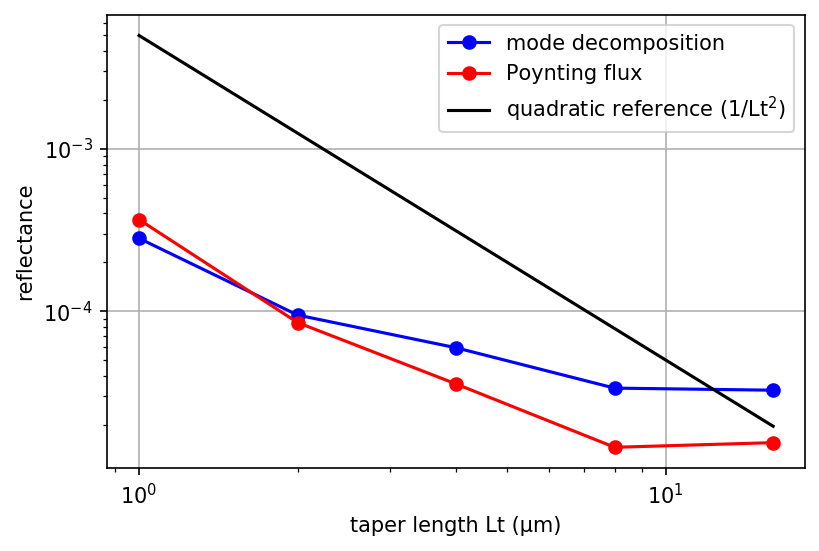

In [20]:
plt.figure(dpi=150)
plt.loglog(Lt_range,abs(np.array(S11))**2,'bo-',label='mode decomposition')
plt.loglog(Lt_range,norm_flux,'ro-',label='Poynting flux')
plt.loglog(Lt_range,[0.005/Lt**2 for Lt in Lt_range],'k-',label=r'quadratic reference (1/Lt$^2$)')
plt.legend(loc='upper right')
plt.xlabel('taper length Lt (μm)')
plt.ylabel('reflectance')
plt.grid(True)
plt.show()